## Importing libraries

In [1]:
from __future__ import print_function
from pylab import *

%matplotlib inline

import skimage 
from skimage import img_as_float
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu

from skimage import io

import numpy as np
import pandas as pd

import scipy 
from scipy import ndimage

import cv2

import pytesseract
from pytesseract import pytesseract
pytesseract.tesseract_cmd = r'C:\Users\Jovan Dmitrovic\AppData\Local\Programs\Tesseract-OCR\tesseract.exe'


## Dictionary for PyTesseract Languages

In [2]:
tesseract_langs = { 'serbian_cirilic': 'srp',
                    'serbian_latin': 'srp_latn',
                    'italian': 'ita',
                    'french': 'fra',
                    'german': 'deu',
                    'english': 'eng'}

##  Skimage - Image preproccesing

Image dimensions : (1259, 3821, 3)
Max image value : 219


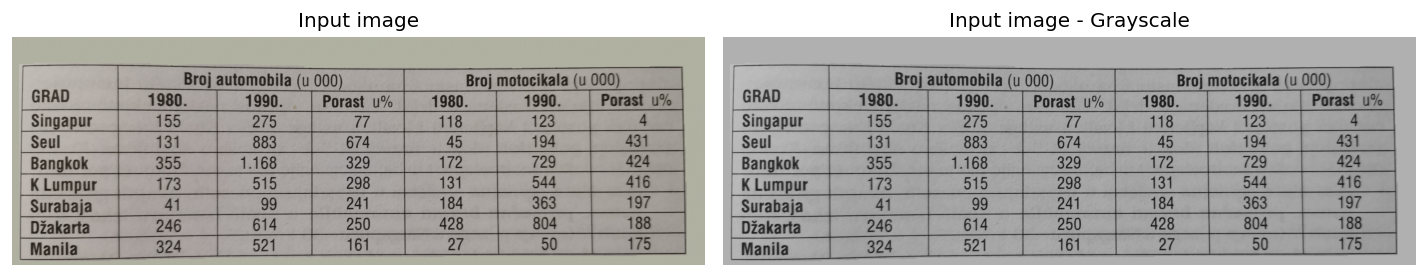

In [3]:
img_name = 'serbian_latin' # image name should bi set as language of table written

# raise error if language is not suported
if img_name not in tesseract_langs.keys():
    raise Exception('Not supported language')

img_ext = '.jpg'
img = io.imread(img_name + img_ext)

img_dimensions = shape(img)
print('Image dimensions : ' + str(img_dimensions))
print('Max image value : ' + str(img.flatten().max()))

img = img/255.0

img_gray = rgb2gray(img)

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 12), dpi = 120)

ax[0].imshow(img, cmap='jet',  vmin = 0, vmax = 1);
ax[0].set_title('Input image')
ax[0].set_axis_off()

ax[1].imshow(img_gray, cmap='gray', vmin = 0, vmax = 1);
ax[1].set_title('Input image - Grayscale')
ax[1].set_axis_off()

plt.tight_layout()
plt.show()

## Image Otsu thresholding

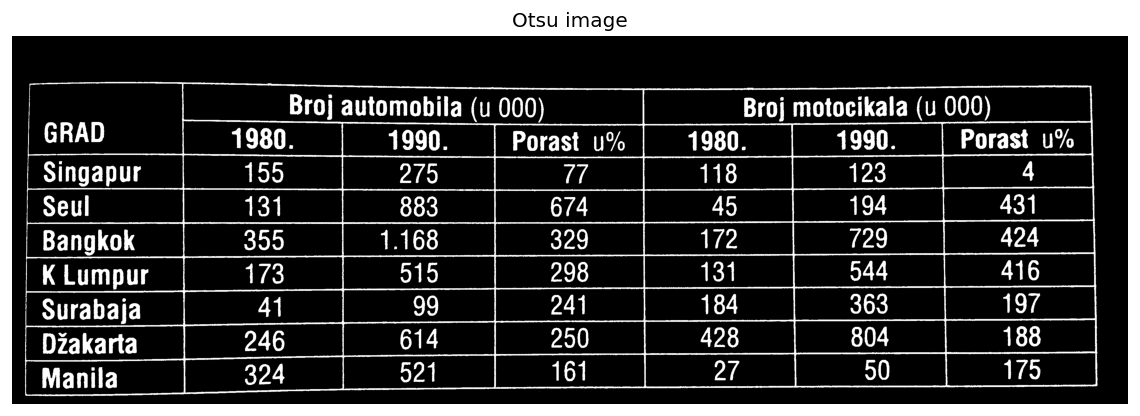

In [4]:
t_otsu = threshold_otsu(img_gray)
img_otsu = img_gray < t_otsu

img_otsu_name = img_name + '_otsu' + img_ext

io.imsave(img_otsu_name, uint8(255*img_otsu))

figure(figsize = (12, 12), dpi = 120);
imshow(img_otsu, cmap='gray',  vmin = 0, vmax = 1);
plt.title('Otsu image')
plt.axis('off')
plt.show();

## Morhpological image filtering for extraction of verical and horizontal lines of table

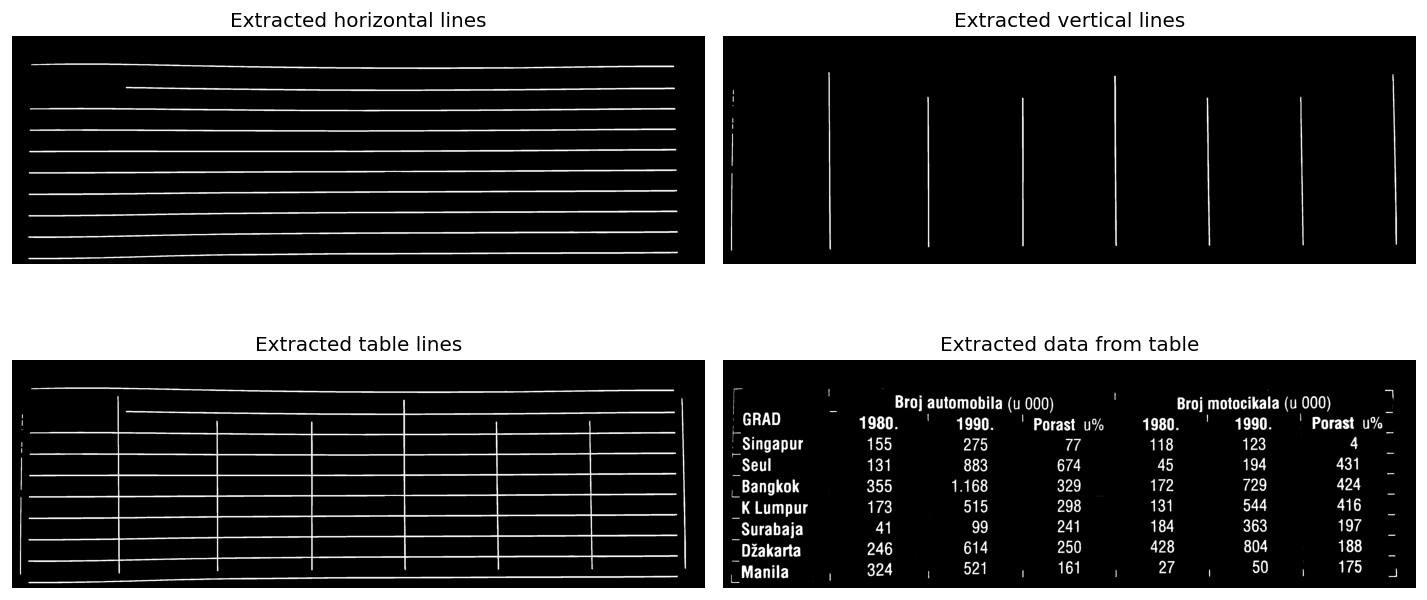

In [5]:
from skimage.morphology import dilation, erosion, disk, square

kernel_len = img_dimensions[1]//40

kernel_for_horiz = 1/kernel_len * np.ones((1, kernel_len))

kernel_for_vert= 1/kernel_len * np.ones((kernel_len, 1))

img_horizontals = ndimage.correlate(img_otsu, kernel_for_horiz)
img_horizontals = dilation(img_horizontals, disk(radius=5))
horizontal_lines = erosion(img_horizontals, disk(radius = 3))

img_verticals = ndimage.correlate(img_otsu, kernel_for_vert)
img_verticals = dilation(img_verticals, disk(radius=5))
vertical_lines = erosion(img_verticals, disk(radius = 3))

table_lines = horizontal_lines + vertical_lines

img_table_lines_name = img_name + '_table_lines' + img_ext

io.imsave(img_table_lines_name, uint8(255*table_lines))

data = img_otsu*(~(table_lines))

fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (12, 6), dpi = 120)
ax = axes.ravel()

ax[0].imshow(horizontal_lines, cmap='gray',  vmin = 0, vmax = 1);
ax[0].set_title('Extracted horizontal lines')
ax[0].set_axis_off()

ax[1].imshow(vertical_lines, cmap='gray', vmin = 0, vmax = 1);
ax[1].set_title('Extracted vertical lines')
ax[1].set_axis_off()

ax[2].imshow(table_lines, cmap='gray', vmin = 0, vmax = 1);
ax[2].set_title('Extracted table lines')
ax[2].set_axis_off()

ax[3].imshow(data, cmap='gray', vmin = 0, vmax = 1);
ax[3].set_title('Extracted data from table')
ax[3].set_axis_off()

plt.tight_layout()
plt.show()

## OpenCV - Contours extraction and drawing

In [6]:
img_otsu_cv2 = cv2.imread(img_otsu_name)
im_otsu_cv2_gray = cv2.cvtColor(img_otsu_cv2, cv2.COLOR_BGR2GRAY)

img_table_lines_cv2 = cv2.imread(img_table_lines_name)
im_table_lines_cv2_gray = cv2.cvtColor(img_table_lines_cv2, cv2.COLOR_BGR2GRAY)
contours, hierarchy = cv2.findContours(im_table_lines_cv2_gray, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

img_contours = np.zeros(img.shape)
cv2.drawContours(img_contours, contours, -1, (0,255,0), 3)
cv2.imwrite(img_name + '_contours'+img_ext,img_contours) 

True

## Box extraction 

## PyTesseract - Extraction of data in all particular boxes

## Pandas - Storing extracted data